In [1]:
import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.curriculum import Curriculum, default_metric
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [2]:
dt = 10 # time-step
tau = 100 # intrinsic time constant of neural state decay
T = 2000 # time to run for (number of steps is T/dt)
N_batch = 50 # number of trials per training step
N_rec = 50 # number of recurrent units
name = 'curriculumModel'

We generate a list of tasks that constitute are curriculum. We will train on these tasks one after another. In this example, we train the network on tasks with higher coherence, slowly decreasing to lower coherence.

In [3]:
rdms = [rd.RDM(dt = dt, tau = tau, T = T, N_batch = N_batch, coherence = i*.1) for i in range(10,0,-2)]

We add in a few params that Basic(RNN) needs but that RDM doesn't generate for us.

In [4]:
params = rdms[0].__dict__
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec

Instantiate two models. *curriculumModel* that will be trained on the series of tasks, rdms, defined above. *basicModel* will be trained only on the final task with lowest coherence.

In [5]:
curriculumModel = Basic(params)
params['name'] = 'basicModel'
basicModel = Basic(params)

{'N_batch': 50, 'N_in': 2, 'N_out': 2, 'dt': 10, 'tau': 100, 'T': 2000, 'alpha': 0.1, 'N_steps': 200, 'coherence': 1.0, 'name': 'curriculumModel', 'N_rec': 50, 'parent': True}
{'N_batch': 50, 'N_in': 2, 'N_out': 2, 'dt': 10, 'tau': 100, 'T': 2000, 'alpha': 0.1, 'N_steps': 200, 'coherence': 1.0, 'name': 'basicModel', 'N_rec': 50, 'parent': True}


Start a tensorflow session with loss, regularization, predictions, and regularized loss defined.

In [6]:
basicModel.build()
curriculumModel.build()

Set options for the curriculum object.

In [7]:
metric = default_metric # optional custom defined metric function with signature metric(curriculum_params, input_data, correct_output, output_mask, output, epoch, losses, verbosity), outputs (bool: advanceStage, float: metricValue)
accuracies = [rdms[i].accuracy_function for i in range(len(rdms))] # optional list of function to use to calculate network performance for the purposes of advancing tasks . default: [tasks[i].accuracy_function for i in range(len(tasks))]
thresholds = [.9 for i in range(len(rdms))] # optional list of thresholds that must be hit as defined in metric before advancing stage. default: [.9 for i in range(len(tasks))]
metric_epoch = 10 # optional int for how often to evaluate the metric function to see if it is time to advance stage. default: 10
output_file = None # where to save out the metric_values. If None, values will not be saved. default: None

Initialize a curriculum object with information about the tasks we want to train on.

In [8]:
curriculum = Curriculum(rdms, output_file=output_file, metric_epoch=metric_epoch, thresholds =thresholds, accuracies =accuracies, metric=metric)

Set the training parameters for our model. All of the parameters below are optional.

In [9]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 10000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params['curriculum'] = curriculum

Train our model.

In [10]:
curriculum_losses, _,_ = curriculumModel.train(None, train_params)
train_params['curriculum'] = None
basic_losses,_,_ = basicModel.train(rdms[len(rdms)-1].batch_generator(), train_params)

Iter 500, Minibatch Loss= 0.140583
Accuracy: 0.48
Iter 1000, Minibatch Loss= 0.123719
Accuracy: 0.82
Iter 1500, Minibatch Loss= 0.132187
Accuracy: 0.96
Stage 1
Iter 2000, Minibatch Loss= 0.124057
Accuracy: 0.48
Iter 2500, Minibatch Loss= 0.116385
Accuracy: 1.0
Stage 2
Iter 3000, Minibatch Loss= 0.094105
Accuracy: 1.0
Stage 3
Iter 3500, Minibatch Loss= 0.046751
Accuracy: 1.0
Stage 4
Iter 4000, Minibatch Loss= 0.068975
Accuracy: 0.7
Iter 4500, Minibatch Loss= 0.041405
Accuracy: 0.96
Stage 5
Optimization finished!
Model saved in file: ../weights/refactor_weights.npz
Iter 500, Minibatch Loss= 0.145266
Iter 1000, Minibatch Loss= 0.132266
Iter 1500, Minibatch Loss= 0.135781
Iter 2000, Minibatch Loss= 0.125337
Iter 2500, Minibatch Loss= 0.129406
Iter 3000, Minibatch Loss= 0.112514
Iter 3500, Minibatch Loss= 0.118183
Iter 4000, Minibatch Loss= 0.127108
Iter 4500, Minibatch Loss= 0.116417
Iter 5000, Minibatch Loss= 0.125778
Iter 5500, Minibatch Loss= 0.123415
Iter 6000, Minibatch Loss= 0.134266

### Plot results

Extract the next trial from the generator

In [11]:
gen = rdms[len(rdms) - 1].batch_generator()
x,y,m,_ = next(gen)

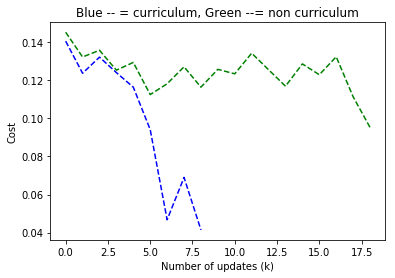

In [12]:
plt.plot( curriculum_losses, 'b--')
plt.plot(basic_losses, 'g--')
plt.title("Blue -- = curriculum, Green --= non curriculum")
plt.ylabel('Cost')
plt.xlabel('Number of updates (k)')
plt.show()

Clean up the model to clear out the tensorflow namespace

In [13]:
basicModel.destruct()

In [14]:
curriculumModel.destruct()